Initialize the script by importing the right packages and enabling proper settings

In [1]:
# Mute warnings for torchvision v2
import torchvision
torchvision.disable_beta_transforms_warning()

# Importing necessary packags
import numpy as np
import torch
from torchvision.models import mobilenet_v3_large
import torchvision.transforms.v2 as F  
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tools.dataset import FacialExpressionDataset
from tools.engine import train_epoch, val_epoch
from random import randint

# Enabling autoreload
%load_ext autoreload
%autoreload 2

# Define device as GPU if cuda available, otherwise cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Define datasets for training and validation

In [2]:
train_transform = F.RandomOrder([
                F.RandomRotation(degrees=[0, 360]),
                F.RandomInvert(p=0.1),
                # F.RandomHorizontalFlip(p=0.2),
                # F.RandomPerspective(distortion_scale=0.9, p=0.9),
                # F.ElasticTransform(alpha=250.0),
                # F.RandomVerticalFlip(p=0.2),
                # F.ColorJitter(),
                F.RandomGrayscale(),
                # # F:RandomAffine(),
                F.RandomResizedCrop(size=(256, 256), antialias=True),
                # F.RandomPosterize(6),
                F.RandomErasing(p=0.1)
            ])

In [3]:
dataset_train = FacialExpressionDataset(train_transform=train_transform, device=device)
dataset_val = FacialExpressionDataset(device=device)

if not "indices" in locals():
    indices = torch.randperm(len(dataset_train)).tolist()

dataset_train = torch.utils.data.Subset(dataset_train, indices[:(round(len(indices)*0.75))])
dataset_val = torch.utils.data.Subset(dataset_val, indices[(round(len(indices)*0.75)):])

Define dataloaders 

In [4]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset_train, BATCH_SIZE, 
                          num_workers=0, shuffle=True,
                             drop_last=False, pin_memory=True)

val_loader = DataLoader(dataset_val, BATCH_SIZE, 
                          num_workers=0, shuffle=False,
                             drop_last=False, pin_memory=True)

Create the model

In [5]:
# Import googlenet with pretrained weights from torchvision
model = mobilenet_v3_large(weights="DEFAULT")

# Modify the last layer to output the amount of classes we have
model.classifier[3] = torch.nn.Linear(in_features=model.classifier[3].in_features,
                           out_features=len(dataset_train.dataset.classes))

model = model.to(device)

Define the optimizer and loss function

In [6]:
# Adam with default parameters
optimizer = Adam(model.classifier.parameters(), lr=1e-5)

# Cross-entropy loss for multiclass classification
loss_fn = CrossEntropyLoss().to(device)

Train for 100 epochs

In [7]:
end = 500
val_losses = [None]*end
train_losses = [None]*end
val_accs = [None]*end
train_accs = [None]*end

for epoch in range(0, end):

    train_loss, train_acc = train_epoch(model, train_loader, device, optimizer, loss_fn)
    val_loss, val_acc = val_epoch(model, val_loader, device, optimizer, loss_fn)

    train_losses[epoch] = train_loss
    train_accs[epoch] = train_acc

    val_losses[epoch] = val_loss
    val_accs[epoch] = val_loss

    print(f"Epoch {epoch:4d}  train_loss {train_loss:.4f}  train_acc {train_acc:.2f}%  val_loss {val_loss:.4f}  val_acc {val_acc:.2f}%")

Epoch    0  train_loss 1.3878  train_acc 27.66%  val_loss 1.2978  val_acc 40.56%
Epoch    1  train_loss 1.3436  train_acc 34.26%  val_loss 1.2865  val_acc 42.04%
Epoch    2  train_loss 1.3888  train_acc 34.75%  val_loss 1.2629  val_acc 43.99%
Epoch    3  train_loss 1.3991  train_acc 37.87%  val_loss 1.5406  val_acc 45.82%
Epoch    4  train_loss 1.7840  train_acc 37.24%  val_loss 1.8646  val_acc 36.09%
Epoch    5  train_loss 1.4934  train_acc 37.30%  val_loss 1.2359  val_acc 44.95%
Epoch    6  train_loss 1.7447  train_acc 28.40%  val_loss 1.4822  val_acc 37.23%
Epoch    7  train_loss 1.6184  train_acc 32.09%  val_loss 1.4869  val_acc 41.89%
Epoch    8  train_loss 1.7215  train_acc 35.92%  val_loss 1.8981  val_acc 32.66%
Epoch    9  train_loss 1.9435  train_acc 27.10%  val_loss 1.3666  val_acc 28.67%
Epoch   10  train_loss 1.3757  train_acc 36.55%  val_loss 1.3579  val_acc 41.14%
Epoch   11  train_loss 1.6778  train_acc 32.35%  val_loss 1.4374  val_acc 38.79%
Epoch   12  train_loss 1.505

KeyboardInterrupt: 

Print an image and show the emotion as the title

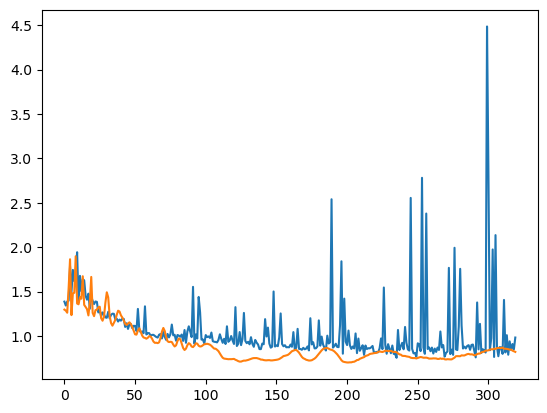

In [8]:
plt.plot(train_losses)
plt.plot(val_losses)

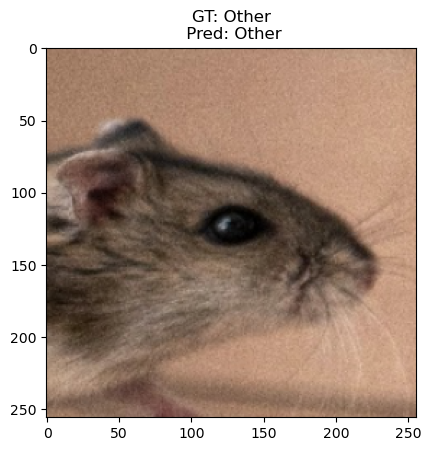

In [33]:
model.eval()
img, label = dataset_train[randint(0, len(dataset_val)-1)]
img, label = next(iter(train_loader))
pred = torch.argmax(torch.softmax(model(img[None,:].to(device)), dim=1), dim=1)
img = img.permute(1, 2, 0).to(device)
plt.title("GT: " + dataset_train.dataset.classes[label] + "\n Pred: " + dataset_train.dataset.classes[pred.item()])
plt.imshow(img.detach().cpu())